In [1]:
import torch
import numpy as np
from matplotlib import pyplot
import os

import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt
import pandas as pd
import random 
from sklearn.metrics import accuracy_score

In [ ]:
train = datasets.FashionMNIST(root = "FashionMNIST/processed/training.pt", train = True, download = True)
test  = datasets.FashionMNIST(root = "FashionMNIST/processed/test.pt", train = False,  download = True)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

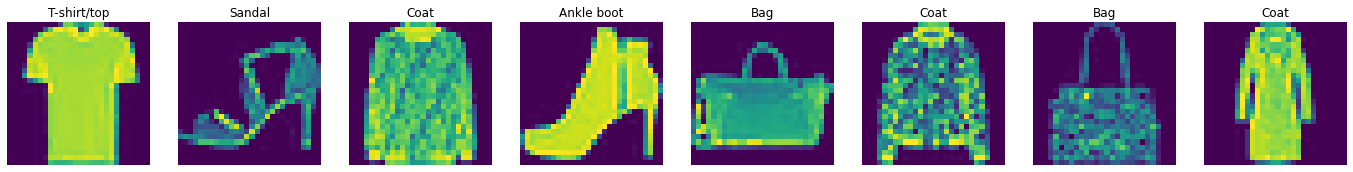

In [3]:
r, c = 1, 8
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
def cross_entropy(output, target):
    #funcion de perdida
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

def softmax(x):
    """distribucion de probabilidad"""
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    """saca la probabilidad mas alta, para clasificar"""
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

def build_model(D_in=784, H=100, D_out=10):
    model = Model(D_in, H, D_out)
    model.to("cuda")
    return model

class Model(torch.nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H1)
        self.relu = torch.nn.ReLU()      
        self.fc2 = torch.nn.Linear(H1, D_out)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
X_train, X_test = train.data, test.data
Y_train, Y_test = train.targets, test.targets

X_train, X_test = torch.flatten(X_train, start_dim=1), torch.flatten(X_test, start_dim=1)

X_train, X_test = (X_train.numpy())/255., X_test.numpy()/255
Y_train, Y_test = Y_train.numpy(), Y_test.numpy()

aux, aux1 = X_train, Y_train

X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(Y_train).long().cuda()

In [6]:
model = build_model()
criterion = torch.nn.CrossEntropyLoss()#funcion de perdida
optimizer = torch.optim.SGD(model.parameters(), lr=0.8)#descenso por el gradiente

epochs = 50
log_each = 10
l = []
model.train()
y_pred = 1
for e in range(1, epochs+1): 
    # forward
    y_pred = model(X_t)

    # loss
    loss = criterion(y_pred, Y_t)
    l.append(loss.item())
    
    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()
    
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.3f}")
        
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(Y_test, y_pred.cpu().numpy())

Epoch 10/50 Loss 2.255
Epoch 20/50 Loss 2.065
Epoch 30/50 Loss 1.999
Epoch 40/50 Loss 1.895
Epoch 50/50 Loss 1.804


0.5383

2da parte

In [7]:
X_train, X_test = train.data, test.data
Y_train, Y_test = train.targets, test.targets

X_train, X_test = torch.flatten(X_train, start_dim=1), torch.flatten(X_test, start_dim=1)

X_train, X_test = (X_train.numpy())/255., X_test.numpy()/255
Y_train, Y_test = Y_train.numpy(), Y_test.numpy()

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().cuda()
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
dataset = Dataset(X_train, Y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [9]:
def fit(model, dataloader, epochs=50, log_each=10):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    model.train()
    l, acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc}

In [10]:
model = build_model()
hist = fit(model, dataloader)
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(Y_test, y_pred.cpu().numpy())

Epoch 10/50 loss 1.14032 acc 0.53937
Epoch 20/50 loss 1.13695 acc 0.54015
Epoch 30/50 loss 1.47173 acc 0.40492
Epoch 40/50 loss 1.90115 acc 0.29367
Epoch 50/50 loss 1.86134 acc 0.29447


0.1545

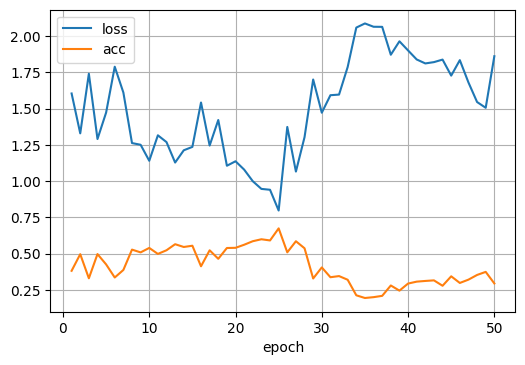

In [11]:
fig = plt.figure(dpi=100)
ax = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', grid=True, ax=ax)
plt.show()

In [12]:
X_train, X_val, X_test = aux[:55000] / 255., aux[55000:] / 255. , X_test
Y_train, Y_val, Y_test = aux1[:55000].astype(np.int), aux1[55000:].astype(np.int), Y_test

X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [13]:
dataset = {
    'train': Dataset(X_train, Y_train),
    'val': Dataset(X_val, Y_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

In [14]:
#porque la diferenci si aqui solo mostramos lo de validacion
def fit(model, dataloader, epochs=10, log_each=1):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [15]:
model = build_model()
hist = fit(model, dataloader, epochs=100, log_each=10)

Epoch 10/100 loss 1.71579 acc 0.30053 val_loss 1.83682 val_acc 0.22220
Epoch 20/100 loss 1.35100 acc 0.45769 val_loss 1.27278 val_acc 0.43980
Epoch 30/100 loss 1.23750 acc 0.50991 val_loss 1.71417 val_acc 0.36920
Epoch 40/100 loss 1.13811 acc 0.55189 val_loss 1.05640 val_acc 0.58920
Epoch 50/100 loss 1.06535 acc 0.57436 val_loss 0.97447 val_acc 0.59640
Epoch 60/100 loss 1.02114 acc 0.59089 val_loss 0.93802 val_acc 0.64040
Epoch 70/100 loss 1.12172 acc 0.58524 val_loss 1.03518 val_acc 0.56680
Epoch 80/100 loss 0.99822 acc 0.60120 val_loss 0.91971 val_acc 0.63320
Epoch 90/100 loss 0.97478 acc 0.61033 val_loss 1.17815 val_acc 0.51740
Epoch 100/100 loss 1.01657 acc 0.60804 val_loss 0.92572 val_acc 0.63680


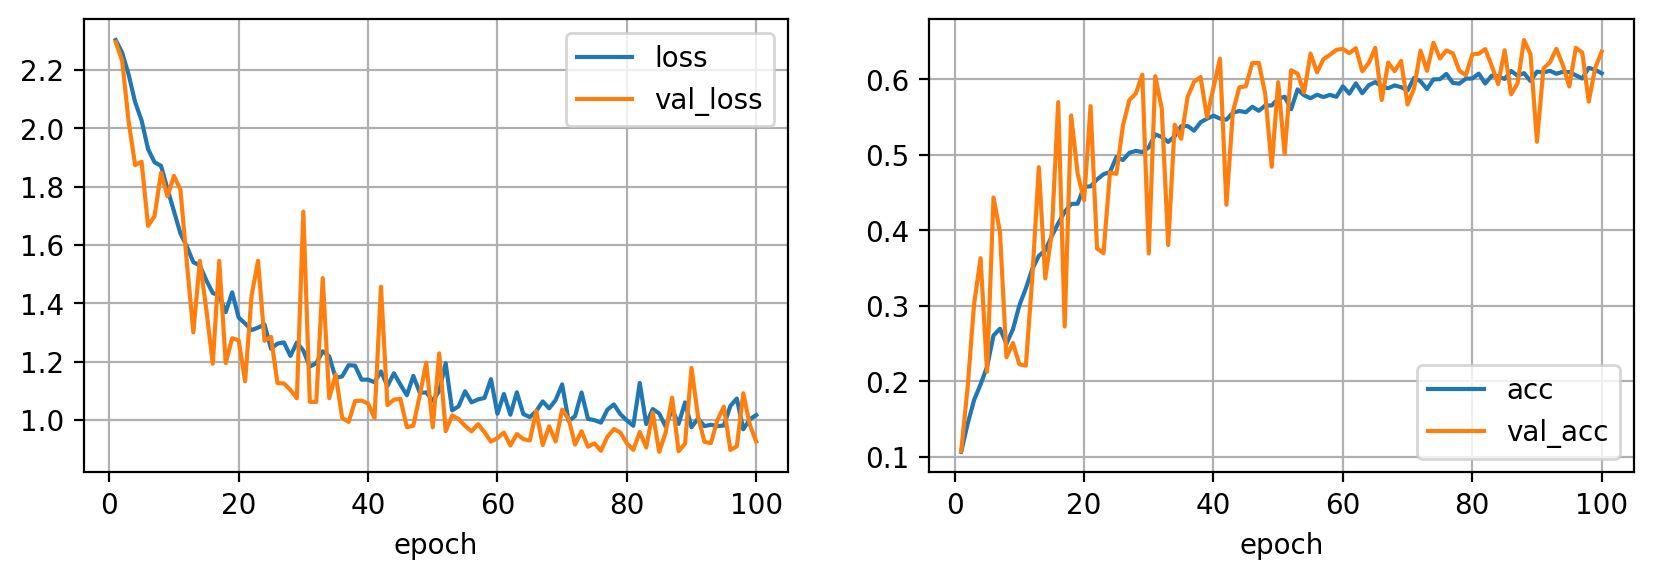

In [16]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [17]:
from sklearn.model_selection import KFold

FOLDS = 4
kf = KFold(n_splits=FOLDS)

#procesado de datos
X_train, X_test = train.data, test.data
Y_train, Y_test = train.targets, test.targets

X_train, X_test = torch.flatten(X_train, start_dim=1), torch.flatten(X_test, start_dim=1)


X_train, X_test = (X_train.numpy())/255., X_test.numpy()/255
Y_train, Y_test = Y_train.numpy(), Y_test.numpy()


X_train.shape, X_test.shape, kf.get_n_splits(train.data)

((60000, 784), (10000, 784), 4)

In [18]:
train_accs, val_accs = [], []
for k, (train_index, val_index) in enumerate(kf.split(X_test)):
    print("Fold:", k+1)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    dataset = {
        'train': Dataset(X_train_fold, Y_train_fold),
        'val': Dataset(X_val_fold, Y_val_fold)
    }

    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    
    model = build_model()
    hist = fit(model, dataloader)
    
    train_accs.append(hist['acc'][-1])   
    val_accs.append(hist['val_acc'][-1])

Fold: 1
Epoch 1/10 loss 1.92077 acc 0.33360 val_loss 1.24953 val_acc 0.47567
Epoch 2/10 loss 1.54733 acc 0.40373 val_loss 1.35542 val_acc 0.46200
Epoch 3/10 loss 1.36527 acc 0.45627 val_loss 0.97656 val_acc 0.62667
Epoch 4/10 loss 1.30256 acc 0.48320 val_loss 1.15934 val_acc 0.55100
Epoch 5/10 loss 1.46425 acc 0.42093 val_loss 1.77038 val_acc 0.35533
Epoch 6/10 loss 2.08520 acc 0.24000 val_loss 1.72505 val_acc 0.29767
Epoch 7/10 loss 1.73200 acc 0.32533 val_loss 1.70823 val_acc 0.31933
Epoch 8/10 loss 1.58604 acc 0.36160 val_loss 1.46398 val_acc 0.39167
Epoch 9/10 loss 1.54823 acc 0.42627 val_loss 2.11791 val_acc 0.26100
Epoch 10/10 loss 1.25591 acc 0.50693 val_loss 1.03337 val_acc 0.56300
Fold: 2
Epoch 1/10 loss 1.91393 acc 0.28800 val_loss 1.76874 val_acc 0.35300
Epoch 2/10 loss 1.43255 acc 0.43933 val_loss 1.78919 val_acc 0.35167
Epoch 3/10 loss 1.69682 acc 0.38747 val_loss 1.84226 val_acc 0.32933
Epoch 4/10 loss 1.53012 acc 0.39560 val_loss 1.58321 val_acc 0.35467
Epoch 5/10 loss 1

In [19]:
np.mean(train_accs), np.std(train_accs)

(0.44419999999999993, 0.051577299054698204)

In [20]:
np.mean(val_accs), np.std(val_accs)

(0.47616666666666674, 0.06802144269762783)

3ra parte

In [21]:
X_train, X_val, X_test = aux[:55000] / 255., aux[55000:] / 255. , X_test
Y_train, Y_val, Y_test = aux1[:55000].astype(np.int), aux1[55000:].astype(np.int), Y_test

X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [22]:
dataset = {
    'train': Dataset(X_train, Y_train),
    'val': Dataset(X_val, Y_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

In [23]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [24]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 2.27560 acc 0.25140 val_loss 2.26952 val_acc 0.26080
Epoch 20/100 loss 1.73209 acc 0.44182 val_loss 1.69804 val_acc 0.45500
Epoch 30/100 loss 1.30074 acc 0.53155 val_loss 1.28012 val_acc 0.55080
Epoch 40/100 loss 1.13100 acc 0.58689 val_loss 1.10363 val_acc 0.60480
Epoch 50/100 loss 1.01170 acc 0.63351 val_loss 0.99768 val_acc 0.61740
Epoch 60/100 loss 0.91554 acc 0.67496 val_loss 0.89078 val_acc 0.68100
Epoch 70/100 loss 0.83690 acc 0.70436 val_loss 0.81134 val_acc 0.71340
Epoch 80/100 loss 0.78418 acc 0.71491 val_loss 0.76078 val_acc 0.72320
Epoch 90/100 loss 0.74936 acc 0.72351 val_loss 0.74270 val_acc 0.73640
Epoch 100/100 loss 0.72141 acc 0.73205 val_loss 0.69515 val_acc 0.74580


In [25]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)#lo normal cuanto debemos usar

Epoch 10/100 loss 2.30284 acc 0.09844 val_loss 2.30285 val_acc 0.09000
Epoch 20/100 loss 2.30286 acc 0.09958 val_loss 2.30308 val_acc 0.09000
Epoch 30/100 loss 2.30289 acc 0.09709 val_loss 2.30283 val_acc 0.10160
Epoch 40/100 loss 2.30275 acc 0.10231 val_loss 2.30297 val_acc 0.09940
Epoch 50/100 loss 2.30282 acc 0.10082 val_loss 2.30329 val_acc 0.09340
Epoch 60/100 loss 2.30283 acc 0.09807 val_loss 2.30252 val_acc 0.10160
Epoch 70/100 loss 2.30291 acc 0.09920 val_loss 2.30290 val_acc 0.09000
Epoch 80/100 loss 2.30286 acc 0.09760 val_loss 2.30236 val_acc 0.10440
Epoch 90/100 loss 2.30284 acc 0.10051 val_loss 2.30299 val_acc 0.09800
Epoch 100/100 loss 2.30285 acc 0.10002 val_loss 2.30336 val_acc 0.09000


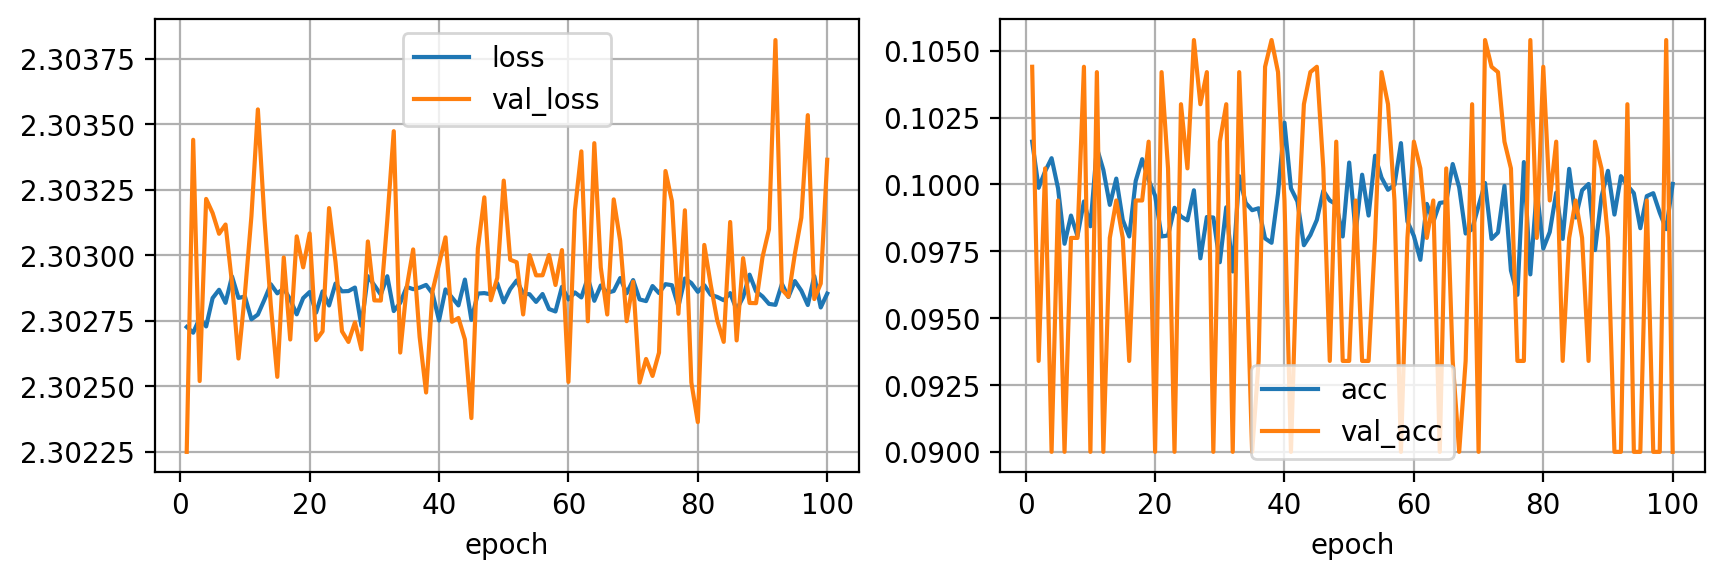

In [26]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [27]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [28]:
model = build_model()
hist = fit(model, dataloader, early_stopping=30)

Mejor modelo guardado con acc 0.09000 en epoch 1
Mejor modelo guardado con acc 0.10420 en epoch 2
Mejor modelo guardado con acc 0.11700 en epoch 4
Mejor modelo guardado con acc 0.20420 en epoch 6
Mejor modelo guardado con acc 0.24300 en epoch 10
Epoch 10/100 loss 2.25819 acc 0.22989 val_loss 2.24828 val_acc 0.24300
Mejor modelo guardado con acc 0.29020 en epoch 12
Mejor modelo guardado con acc 0.34400 en epoch 14
Mejor modelo guardado con acc 0.38060 en epoch 15
Mejor modelo guardado con acc 0.38680 en epoch 16
Mejor modelo guardado con acc 0.39780 en epoch 17
Mejor modelo guardado con acc 0.44420 en epoch 18
Mejor modelo guardado con acc 0.45680 en epoch 20
Epoch 20/100 loss 1.70188 acc 0.43573 val_loss 1.66976 val_acc 0.45680
Mejor modelo guardado con acc 0.48740 en epoch 22
Mejor modelo guardado con acc 0.50840 en epoch 23
Mejor modelo guardado con acc 0.52540 en epoch 25
Mejor modelo guardado con acc 0.53660 en epoch 26
Mejor modelo guardado con acc 0.53920 en epoch 27
Mejor modelo

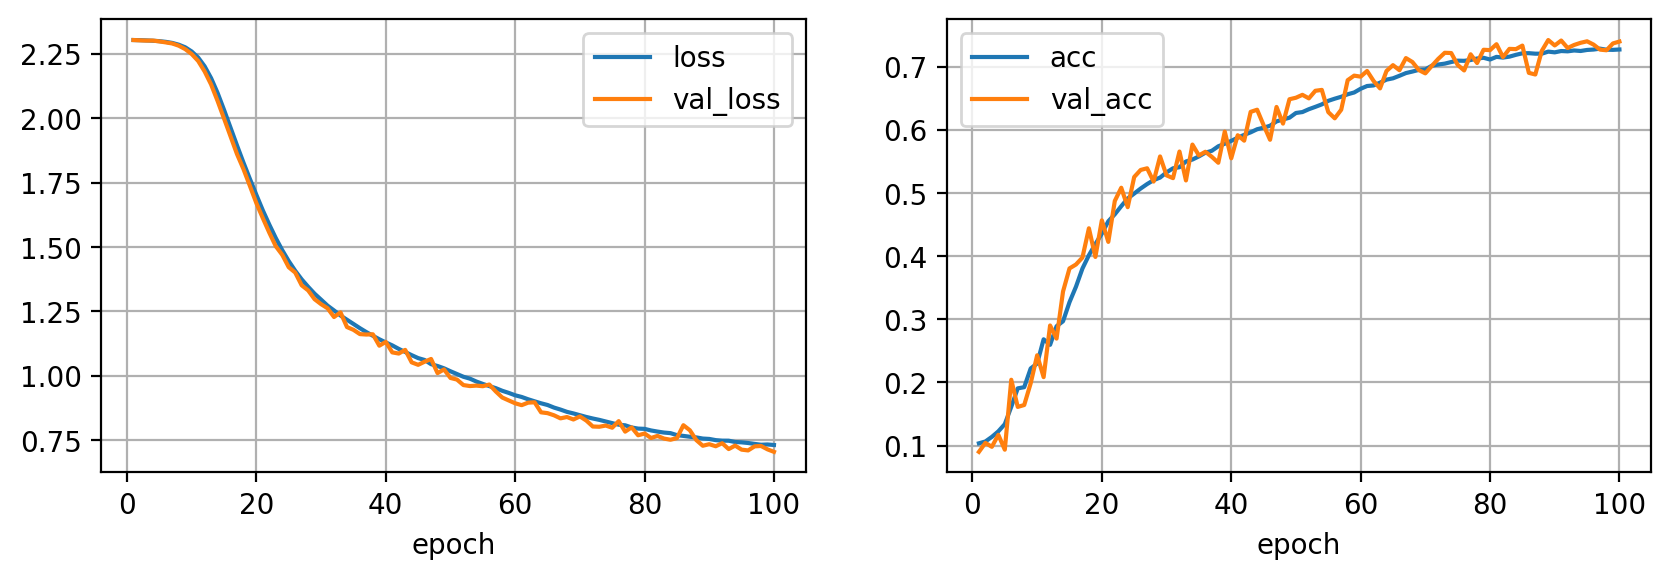

In [29]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [30]:
def build_model(D_in=784, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [31]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.10060 en epoch 1
Mejor modelo guardado con acc 0.10300 en epoch 4
Mejor modelo guardado con acc 0.18880 en epoch 7
Epoch 10/100 loss 2.29749 acc 0.12729 val_loss 2.29639 val_acc 0.16180
Mejor modelo guardado con acc 0.21780 en epoch 12
Mejor modelo guardado con acc 0.23060 en epoch 14
Mejor modelo guardado con acc 0.26900 en epoch 17
Mejor modelo guardado con acc 0.35560 en epoch 19
Epoch 20/100 loss 1.95726 acc 0.20273 val_loss 1.80893 val_acc 0.24560
Mejor modelo guardado con acc 0.40660 en epoch 25
Mejor modelo guardado con acc 0.47340 en epoch 28
Epoch 30/100 loss 1.82338 acc 0.28140 val_loss 2.21547 val_acc 0.15320
Epoch 40/100 loss 2.30290 acc 0.09825 val_loss 2.30282 val_acc 0.10540
Epoch 50/100 loss 2.30295 acc 0.09620 val_loss 2.30276 val_acc 0.09800
Epoch 60/100 loss 2.30284 acc 0.10135 val_loss 2.30270 val_acc 0.09940
Epoch 70/100 loss 2.30288 acc 0.09920 val_loss 2.30281 val_acc 0.10300
Epoch 80/100 loss 2.30289 acc 0.09827 val_loss 2.30335 v

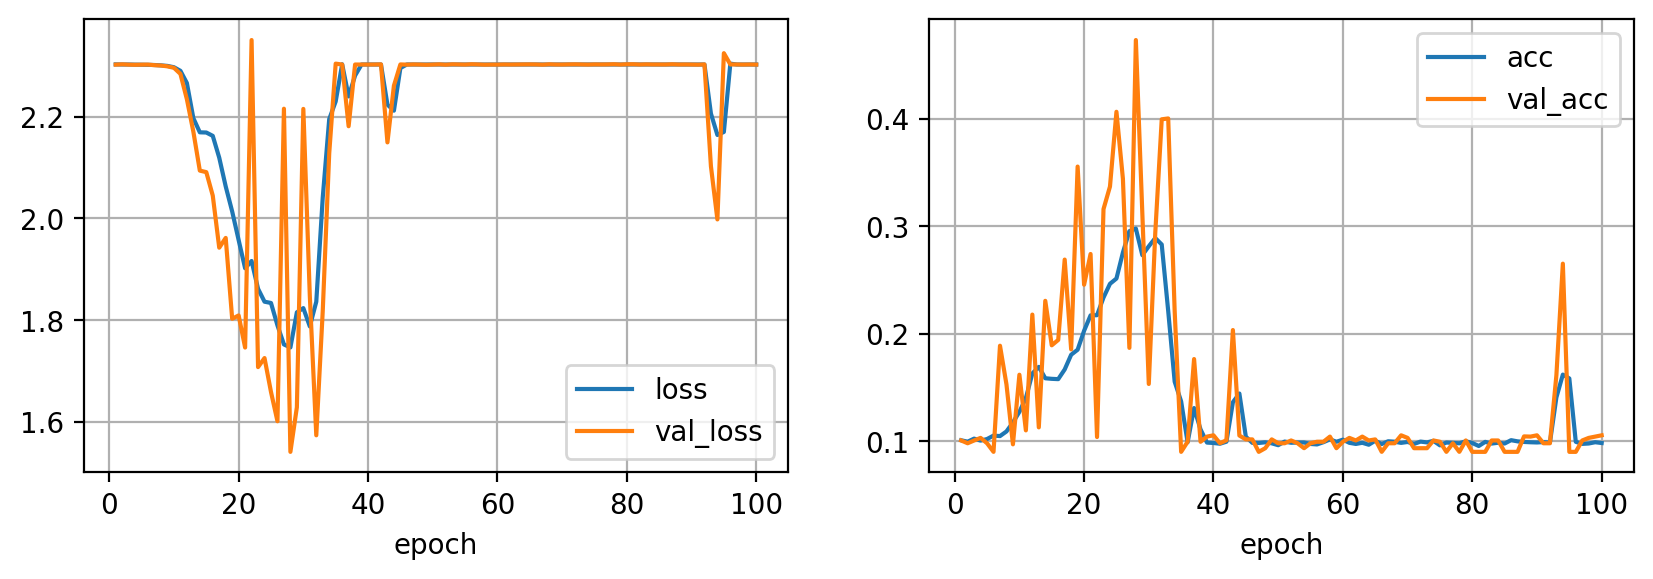

In [32]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

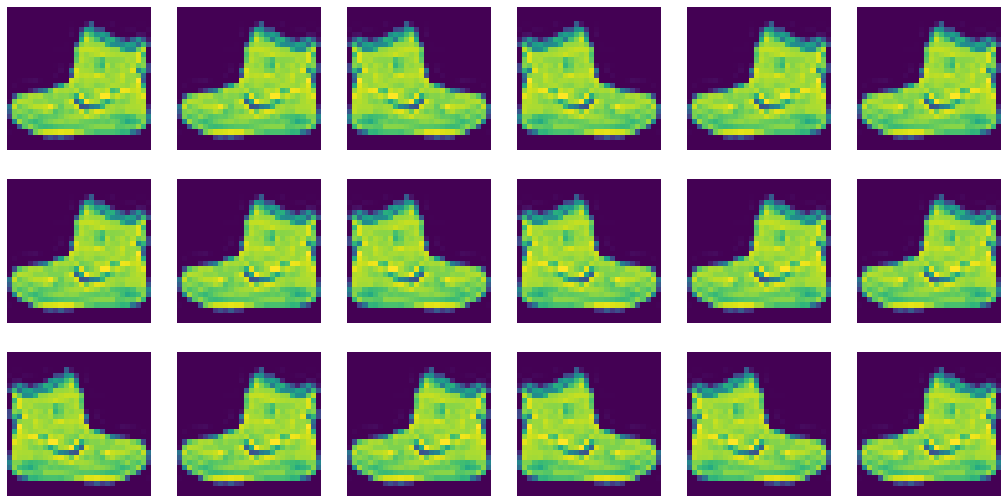

In [33]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    #RandomCrop(24,24),
    Resize(28, 28),
    HorizontalFlip(),
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = train[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [34]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, Y_train, trans=trans),
    'val': Dataset(X_val, Y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=100, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(55000, 5000)

In [35]:
model = build_model()
hist = fit(model, dataloader)

IndexError: ignored

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

4ta parte

In [61]:
X_train, X_val, X_test = aux[:55000] / 255., aux[55000:] / 255. , X_test
Y_train, Y_val, Y_test = aux1[:55000].astype(np.int), aux1[55000:].astype(np.int), Y_test


dataset = {
    'train': Dataset(X_train, Y_train),
    'val': Dataset(X_val, Y_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}


X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [37]:
def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [38]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.10440 en epoch 1
Epoch 10/100 loss 2.30326 acc 0.09960 val_loss 2.30278 val_acc 0.10440
Epoch 20/100 loss 2.30273 acc 0.09836 val_loss 2.30264 val_acc 0.10160
Epoch 30/100 loss 2.30261 acc 0.09985 val_loss 2.30269 val_acc 0.10160
Epoch 40/100 loss 2.30259 acc 0.10091 val_loss 2.30274 val_acc 0.09000
Epoch 50/100 loss 2.30258 acc 0.10091 val_loss 2.30277 val_acc 0.09000
Epoch 60/100 loss 2.30258 acc 0.10091 val_loss 2.30279 val_acc 0.09000
Epoch 70/100 loss 2.30258 acc 0.10091 val_loss 2.30279 val_acc 0.09000
Epoch 80/100 loss 2.30258 acc 0.10091 val_loss 2.30279 val_acc 0.09000
Epoch 90/100 loss 2.30258 acc 0.10091 val_loss 2.30280 val_acc 0.09000
Epoch 100/100 loss 2.30258 acc 0.10091 val_loss 2.30280 val_acc 0.09000


In [39]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.10420 en epoch 1
Epoch 10/100 loss 2.30263 acc 0.10080 val_loss 2.30283 val_acc 0.09000
Epoch 20/100 loss 2.30264 acc 0.09960 val_loss 2.30280 val_acc 0.09000
Epoch 30/100 loss 2.30262 acc 0.10042 val_loss 2.30272 val_acc 0.09340
Epoch 40/100 loss 2.30263 acc 0.09982 val_loss 2.30282 val_acc 0.09000
Epoch 50/100 loss 2.30263 acc 0.09847 val_loss 2.30279 val_acc 0.09000
Epoch 60/100 loss 2.30263 acc 0.10045 val_loss 2.30284 val_acc 0.09000
Epoch 70/100 loss 2.30263 acc 0.09764 val_loss 2.30282 val_acc 0.09000
Epoch 80/100 loss 2.30262 acc 0.09960 val_loss 2.30279 val_acc 0.09000
Epoch 90/100 loss 2.30263 acc 0.10018 val_loss 2.30280 val_acc 0.09000
Epoch 100/100 loss 2.30263 acc 0.10091 val_loss 2.30281 val_acc 0.09000


In [40]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.09000 en epoch 1
Mejor modelo guardado con acc 0.18480 en epoch 2
Mejor modelo guardado con acc 0.21120 en epoch 3
Mejor modelo guardado con acc 0.24440 en epoch 4
Mejor modelo guardado con acc 0.29080 en epoch 5
Mejor modelo guardado con acc 0.33340 en epoch 6
Mejor modelo guardado con acc 0.33960 en epoch 7
Mejor modelo guardado con acc 0.35820 en epoch 9
Epoch 10/100 loss 1.52542 acc 0.34118 val_loss 1.47243 val_acc 0.34780
Mejor modelo guardado con acc 0.37180 en epoch 12
Mejor modelo guardado con acc 0.38220 en epoch 14
Mejor modelo guardado con acc 0.38360 en epoch 15
Mejor modelo guardado con acc 0.38900 en epoch 16
Mejor modelo guardado con acc 0.40440 en epoch 17
Mejor modelo guardado con acc 0.41880 en epoch 20
Epoch 20/100 loss 1.35683 acc 0.39853 val_loss 1.30872 val_acc 0.41880
Mejor modelo guardado con acc 0.43020 en epoch 21
Mejor modelo guardado con acc 0.44100 en epoch 22
Mejor modelo guardado con acc 0.44160 en epoch 24
Mejor modelo gua

In [41]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.10060 en epoch 1
Mejor modelo guardado con acc 0.20220 en epoch 2
Mejor modelo guardado con acc 0.32000 en epoch 3
Mejor modelo guardado con acc 0.38180 en epoch 4
Mejor modelo guardado con acc 0.47040 en epoch 5
Mejor modelo guardado con acc 0.53400 en epoch 6
Mejor modelo guardado con acc 0.55240 en epoch 7
Mejor modelo guardado con acc 0.57360 en epoch 8
Mejor modelo guardado con acc 0.57900 en epoch 9
Mejor modelo guardado con acc 0.62400 en epoch 10
Epoch 10/100 loss 1.02615 acc 0.58973 val_loss 0.98547 val_acc 0.62400
Mejor modelo guardado con acc 0.64240 en epoch 12
Mejor modelo guardado con acc 0.64660 en epoch 13
Mejor modelo guardado con acc 0.66040 en epoch 15
Mejor modelo guardado con acc 0.66680 en epoch 16
Mejor modelo guardado con acc 0.67860 en epoch 18
Mejor modelo guardado con acc 0.68500 en epoch 20
Epoch 20/100 loss 0.87506 acc 0.66044 val_loss 0.84576 val_acc 0.68500
Mejor modelo guardado con acc 0.68780 en epoch 21
Mejor modelo guar

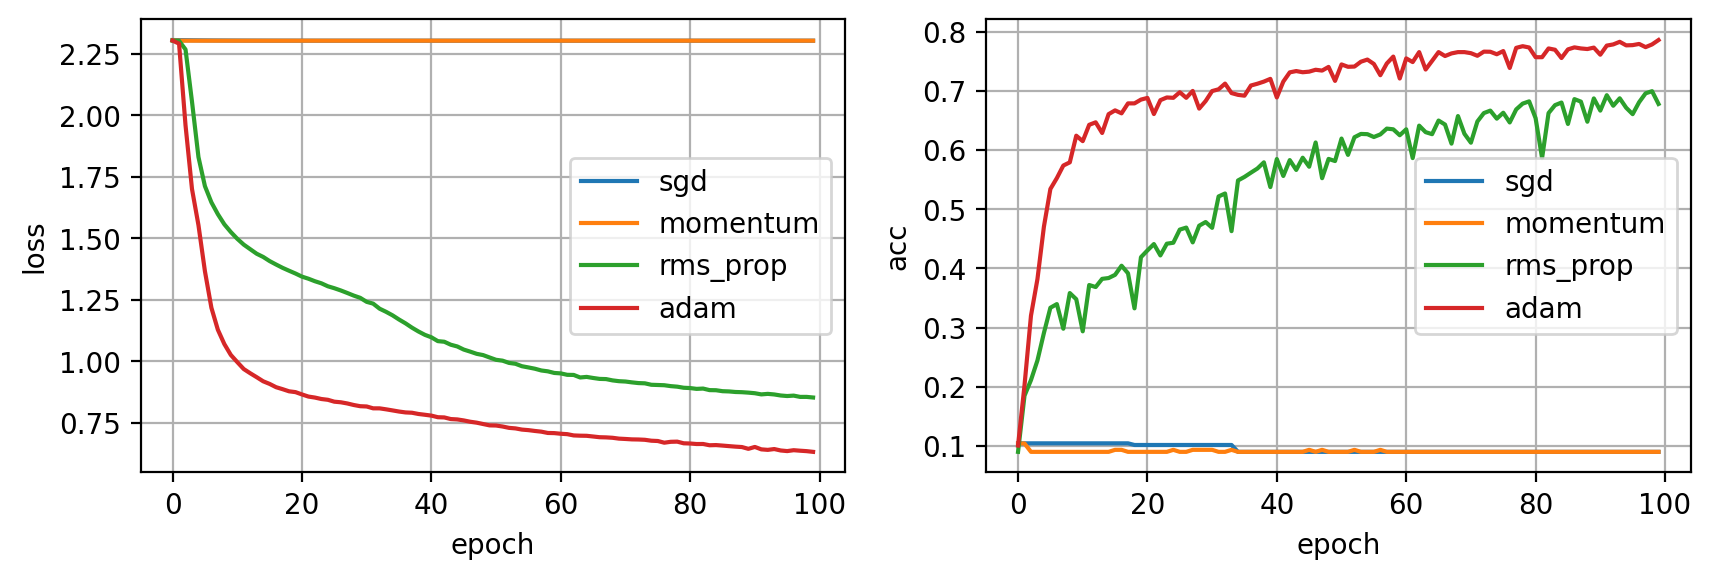

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

In [43]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [44]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# multiplica el lr por 0.1 cada 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.09800 en epoch 1
Mejor modelo guardado con acc 0.09940 en epoch 2
Mejor modelo guardado con acc 0.10440 en epoch 7
Epoch 10/30 loss 2.30289 acc 0.09973 val_loss 2.30300 val_acc 0.09940 lr 0.01000
Epoch 20/30 loss 2.30263 acc 0.10049 val_loss 2.30283 val_acc 0.09000 lr 0.00100
Epoch 30/30 loss 2.30258 acc 0.10091 val_loss 2.30282 val_acc 0.09000 lr 0.00010


In [45]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.09340 en epoch 1
Mejor modelo guardado con acc 0.09940 en epoch 3
Mejor modelo guardado con acc 0.10300 en epoch 10
Epoch 10/30 loss 2.30274 acc 0.09927 val_loss 2.30279 val_acc 0.10300 lr 0.00842
Epoch 20/30 loss 2.30270 acc 0.10062 val_loss 2.30305 val_acc 0.09000 lr 0.00446
Epoch 30/30 loss 2.30260 acc 0.10091 val_loss 2.30282 val_acc 0.09000 lr 0.00050


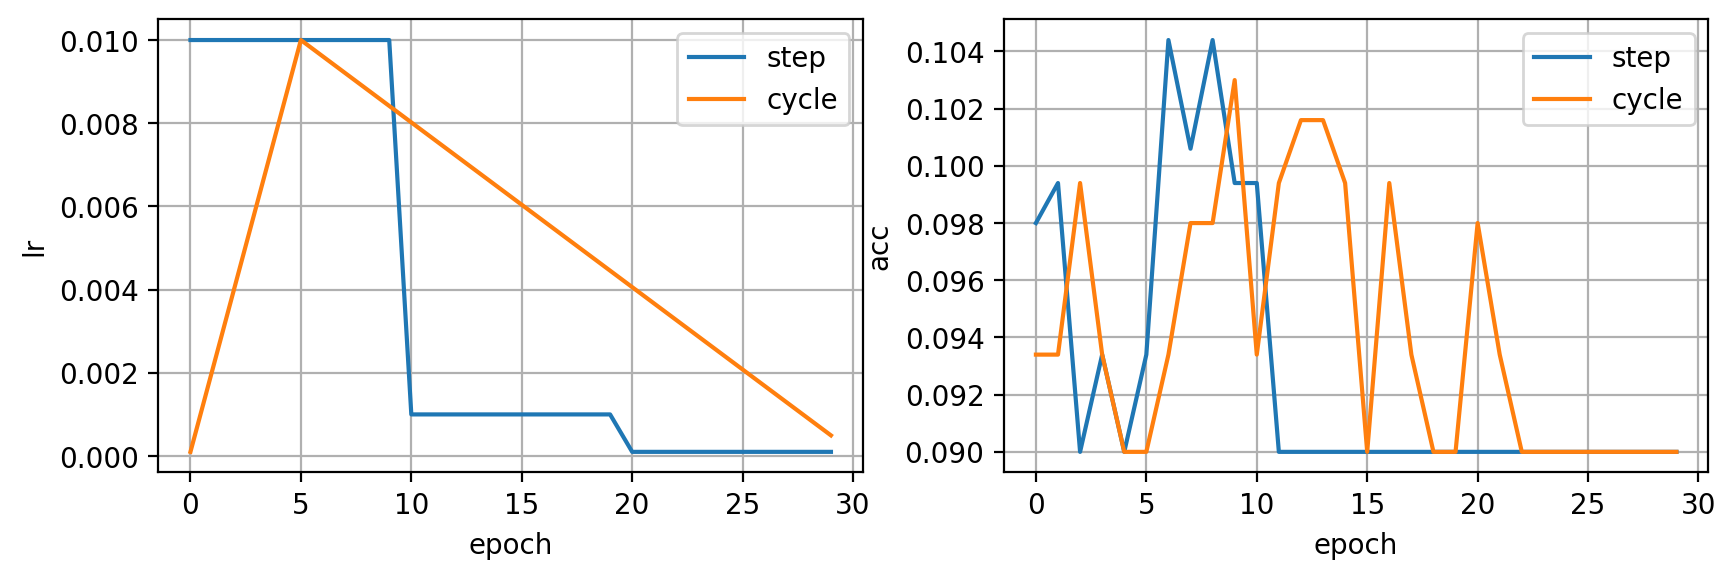

In [46]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Normalización


In [48]:
mean = (train.data / 255).mean(axis=(0, 1, 2))
std = (train.data / 255).std(axis=(0, 1, 2))

mean, std

(tensor(0.2860), tensor(0.3530))

In [49]:
train_images_norm = ((train.data / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(tensor(6.7429e-08), tensor(1.))

In [66]:
type(test)

torchvision.datasets.mnist.FashionMNIST

In [68]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in test.data])
X_train_norm, X_val_norm = train_images_norm[:55000], train_images_norm[55000:]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape

ValueError: ignored

In [ ]:
dataset = {
    'train': Dataset(X_train, Y_train),
    'val': Dataset(X_val, Y_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}


In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

In [ ]:
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()